<a href="https://colab.research.google.com/github/tsilva/aiml-notebooks/blob/main/gymnasium/wip-solving-cartpole_v1-with-reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving CartPole-v1 with REINFORCE 🤖🎮

In this notebook, we'll solve [Gymnasium CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) using **Deep Reinforcement Learning** with **REINFORCE** (aka Vanilla Policy Gradient) 🎮. **REINFORCE** is:
- **Policy-based:** Directly learns a policy, unlike value-based methods (e.g., **DQN**) 📊.
- **On-policy:** The learned policy interacts with the environment 🌍.
- **Model-free:** No knowledge of environment dynamics is required ❌.
- **Monte Carlo:** Updates the policy at the end of an episode, unlike **Temporal Difference (TD)** methods ⏳.

*__Prerequisite:__ Basic knowledge of Neural Networks and PyTorch 🧠. For a deep dive, explore these [notebooks](https://github.com/tsilva/aiml-notebooks/tree/main/karpathy-zero-to-hero) 📚.*

## Introduction

In this notebook, we’ll use **Gymnasium** 🏋️‍♂️, a Python library for building reinforcement learning loops. [Gymnasium](https://gymnasium.farama.org/) provides an API to interact with an **environment** 🌍—a simulated world where an **agent** 🤖 operates. The agent’s goal is to explore, learn from rewards, and develop a policy that maximizes total reward. To do so, the agent follows a cycle:
- Takes an **action** ⚡
- Receives an **observation** 👀(info about the environment’s current **state** 🏞️)
- Earns a **reward** 🎉 (feedback on its action)
- This repeats over an **episode** ⏳ until the environment ends.


Here are key terms you'll need to know while going through this notebook:

- **Environment** 🌍: The world the agent interacts with (e.g., CartPole).  
- **Agent** 🤖: The decision-maker that interacts with the environment.  
- **Policy** 📜: The agent’s strategy for selecting actions based on one or more past observations.  
- **Observation** 👀: The current state of the environment (e.g., in CartPole-v1, this includes cart position, velocity, pole angle, and angular velocity).  
- **Action** ⚡: A decision made by the agent that affects the environment.  
- **Step** 🔄: A single action taken in the environment, resulting in a reward and a new observation.  
- **Reward** 🎉: A numerical value indicating the quality of an action—the higher, the better.  
- **Episode** ⏳: A full interaction with the environment from start to finish (e.g., until the pole falls).  

For more details refer to the [Gymnasium Basic Usage](https://gymnasium.farama.org/introduction/basic_usage/) guide.

## Setup 🛠️

Let's get started and install the necessary packages: 🛠️

In [1]:
!pip install swig
!pip install gymnasium[box2d] # The gymnasium environment
!pip install wandb # Weights & Biases logging
!pip install tsilva-notebook-utils # Personal utils to help with notebook authoring

Here are the key settings we'll use. 🔑 You don't need to know what they are just yet, you'll be able to tweak them after completing the notebook 📝, in order to enhance your results: 🌟

In [2]:
CONFIG = dict(
    seed = 42, # Seed to be used for reproducibility
    env_id = "CartPole-v1", # The environment we want to solve
    discount_factor = 0.99,  # Discount factor controls how much we value future rewards
    hidden_size = 128,  # Neural network hidden layer size (128 gives enough capacity without overfitting)
    learning_rate = 0.002,  # Learning rate for optimizer (0.002 is a safe middle ground for small networks)
    n_train_episodes = 5_000,  # Total training episodes (5k should be more than enough)
    average_reward_window = 10,  # Episodes required for calculating average reward
    average_reward_threshold = None, # Average reward required for environment to be considered solved (defaults to threshold provided in gymnasium env spec)
    normalize_returns = True,  # Whether to normalize returns
    use_log_probs = True, # Whether to use the logarithm of the probability distribution
    use_wandb = True # Whether to log to wandb
)
ORIGINAL_CONFIG = {**CONFIG} # Save original config for reference

Let's set seeds for all packages 🌱 to ensure reproducibility 🔄:

In [3]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # If you're using a GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN (if GPU is used)
    torch.backends.cudnn.benchmark = False  # Disable optimizations that might introduce variability

seed = CONFIG["seed"]
set_seed(seed)

## Inspect Environment 🔍🌍

Set up the environment 🌍:

In [4]:
import gymnasium as gym
env_id = CONFIG["env_id"]
def build_env(env_id): return gym.make(env_id, render_mode="rgb_array")
env = build_env(env_id)
env.observation_space.shape, env.action_space

((4,), Discrete(2))

Observations (states) consist of `4` numbers 🔢, while actions are `0` or `1` ⚖️. The [docs](https://gymnasium.farama.org/environments/classic_control/cart_pole/) provide details on these numbers, but it's not essential as the reinforcement learning algorithm can solve the environment regardless 💪.

Before proceeding, ensure the environment is reproducible. 🔄 Run this cell multiple times; its output should remain consistent. ✅ If it does, you may proceed. 🚀

In [5]:
seed = CONFIG["seed"]
state, _ = env.reset(seed=seed)
[state] + [env.step(0)[0] for _ in range(3)]

[array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 array([ 0.02727336, -0.20172954,  0.03625453,  0.32351476], dtype=float32),
 array([ 0.02323877, -0.39734846,  0.04272482,  0.62740684], dtype=float32),
 array([ 0.0152918 , -0.5930399 ,  0.05527296,  0.9332334 ], dtype=float32)]

Let's establish the reward threshold for this environment to be deemed solved: 🎯

In [6]:
env.spec.reward_threshold

475.0

If the average cumulative reward over multiple episodes exceeds the average reward threshold, the episode is considered solved. 🎉

Let's run the environment for one episode using a random policy 🎲 to observe its behavior 👀:

In [7]:
import numpy as np
from tsilva_notebook_utils.video import render_video

# Define random policy
# NOTE: I can't seem to ensure reproducibility of this
# sampler in the latest version of gymnasium
policy = lambda state: env.action_space.sample()

# Reset environment
seed = CONFIG["seed"]
state, _ = env.reset(seed=seed)

# Run environment step by step until
# it communicates it has finished
rewards = []
frames = []
done = False
while not done:
    # Render current state and collect frame
    frame = env.render()
    frames.append(frame)

    # Get next action from policy
    action = policy(state)

    # Execute action in environment
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Determine if the environment
    # has finished (eg: pole fell,
    # cartpole went off the screen)
    done = terminated or truncated
    state = next_state

    # Collect reward
    rewards.append(reward)

# Log total reward
print(f"Sample rewards: {rewards[:5] + rewards[:-5]}")
print(f"Total Reward: {np.array(rewards).sum()}")

# Render collected environment frames as video
render_video(frames)

Sample rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Total Reward: 16.0


Spoiler: it's bad. 😬 The pole falls quickly because random actions aren't sufficient. You earn a `1.0` reward per step until it crashes, and to win, you must last **500** steps. ⏳ Having observed the poor performance of a random policy, let's explore how **REINFORCE** can train a more effective one. 🚀

## Enter REINFORCE   🤔✨

Our goal is to train a model that maximizes rewards in CartPole-v1 🎮 by learning an effective action selection policy. REINFORCE directly adjusts this policy using complete episode rewards 🏆. As an on-policy, model-free, Monte Carlo algorithm, it learns through trial and error 🔄 without needing environment dynamics, only updating after full episodes.

We'll measure success by total episode rewards 📊 and create a loss function (negative reward) for gradient descent to minimize—thereby maximizing rewards 📈. This simple approach will be refined as we progress. Let's dive in! 🌊


## Create Policy Model 📄✨

To train a policy with **REINFORCE** 🎮, we need a model that adjusts based on policy performance (episode reward) 🏆. **Neural Networks** 🧠 using **Backpropagation** 🔄 and **Gradient Descent** 📉 are ideal. A loss function that increases with poor performance 📈 helps adjust the model's parameters to reinforce good actions 👍 and reduce bad ones 👎 in future episodes.

Let's create the **Neural Network** 🤖 that will encode the desired policy 📜:

In [8]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=None):
        super(PolicyNetwork, self).__init__()

        if hidden_size is None: hidden_size = CONFIG["hidden_size"]

        # Create a multilayer perceptron with just one hidden layer
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size), # Hidden layer (observation_space_size, hidden_layer_size)
            nn.ReLU(), # ReLU activation (for be able to model a non-linear functions)
            nn.Linear(hidden_size, action_dim) # Output layer (hidden_layer_size, action_space_size)
        )

    def forward(self, x):
        return self.net(x)

def build_model(env, seed=None):
    if seed is None: seed = CONFIG["seed"]
    torch.manual_seed(seed)
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    model = PolicyNetwork(input_size, output_size)
    return model

model = build_model(env)

For CartPole's low-dimensional observation space 🌌 and binary action space 🎮, a simple **Multilayer Perceptron** 🧠 with one hidden layer is sufficient. Our network takes **4** observation values as input 🔍 and outputs **2** logits 📊 representing action quality scores.

Let's test our network with an observation 🚀:


In [9]:
with torch.no_grad(): # Don't track gradients during inference
    action_logits = model(torch.tensor(state)) # State is a numpy object, needs to be converted to tensor first
action_logits

tensor([-0.2775, -0.1908])

The higher the logit for an action, the more confident the model is that the action should be taken in that state. 💪 However, since the model is untrained, these logits are currently random. 🎲

Logits alone aren't enough—our untrained model needs to both explore and exploit. By **sampling** actions based on confidence levels 🎲, we:
- Allow exploration of less-favored actions that might yield **surprising rewards** 💰
- Still tend toward the **currently best-known actions** while learning continues 📈

This exploration-exploitation balance is crucial for effective reinforcement learning.


To sample actions based on the model's confidence 🤖, we convert logits into a probability distribution 📊 (values from `0.0` to `1.0` that sum to `1.0`) using the `softmax()` function:

In [10]:
action_probs = torch.softmax(action_logits, dim=-1) # Dim = -1 means the last dimension of the tensor, Dim = 0 would also work in this case
action_probs, action_probs.sum()

(tensor([0.4784, 0.5216]), tensor(1.))

Now, let's sample an action: 🎬✨

In [11]:
action = torch.multinomial(action_probs, 1).item() # Sample 1 action from the probability distribution
action

0

You can run the cell above multiple times 🔄 to obtain different actions. The action with the highest logit 📈 will appear more frequently.

## Create Loss Function

To train our model effectively, we need a smart way to assign credit to actions. Here's our approach:

1. Instead of using the same total reward for all actions, we use **return** 💰—the sum of future rewards from each timestep. Early actions in a successful episode get higher returns (like `200`), while later actions get less (like `1`).

2. Since actions are sampled probabilistically 📊, we scale returns by confidence:
   - High return (`100`) + low confidence (`10%`) = modest update (`10`)
   - Same return + high confidence (`90%`) = strong update (`90`)

3. We use **log probabilities** instead of raw probabilities for:
   - Better numerical stability 🔒
   - Stronger penalties when high-return actions had low confidence
   - More effective gradient signals

By negating this scaled return, we create our **loss function** ⚖️. Minimizing this loss pushes our policy to be more confident in actions that lead to high returns.


Let's implement our loss function step by step. First, we need to collect rewards 🎉 and action log probabilities 📊:

In [12]:
def run_episode(
    env,
    policy,
    use_log_probs=None,
    train_mode=False
):
    if use_log_probs is None: use_log_probs = CONFIG["use_log_probs"]

    # Reset the environment (we don't want to
    # set the seed here because we may or may
    # not want to start from same state depending
    # on the use case)
    state, _ = env.reset()

    # Run environment until it
    # communicates that it has finished
    done = False
    rewards = []
    action_logprobs = []
    frames = []
    while not done:
        # Collect frames when not in training mode
        if not train_mode: frames.append(env.render())

        # Predict action probabilities using the model
        with torch.no_grad() if not train_mode else torch.enable_grad():
            action_logits = policy(torch.tensor(state))
            action_probs = torch.softmax(action_logits, dim=-1)
            action = torch.multinomial(action_probs, 1).item()

        # Collect action log probabilities
        action_prob = action_probs[action]
        action_log_prob = torch.log(action_prob) if use_log_probs else action_prob
        action_logprobs.append(action_log_prob)

        # Step the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store reward and update state
        rewards.append(reward)
        state = next_state

    return rewards, action_logprobs, frames

# Run an episode
rewards, action_logprobs, _ = run_episode(env, model)
rewards[:5], action_logprobs[:5]

([1.0, 1.0, 1.0, 1.0, 1.0],
 [tensor(-0.7961),
  tensor(-0.6631),
  tensor(-0.7942),
  tensor(-0.6654),
  tensor(-0.6033)])

Let's convert rewards to returns by accumulating them from the end to the start of the episode. 🎉📈

In [13]:
def calculate_returns(
    rewards,
    discount_factor=None,
    normalize=None
):
    if discount_factor is None: discount_factor = CONFIG["discount_factor"]
    if normalize is None: normalize = CONFIG["normalize_returns"]

    returns = torch.zeros(len(rewards))
    for t in range(len(returns)-1, -1, -1):
        returns[t] = rewards[t] + discount_factor * (returns[t+1] if t < len(returns)-1 else 0)

    # Normalize values so that they match a normal distribution
    # we only have to subtract the mean of the values and divide by
    # the standard deviation
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8) # NOTE: we add a small value to std() because it can be zero when all values are the same

    return returns

calculate_returns(rewards, normalize=False)

tensor([22.2179, 21.4322, 20.6386, 19.8369, 19.0272, 18.2093, 17.3831, 16.5486,
        15.7057, 14.8542, 13.9942, 13.1254, 12.2479, 11.3615, 10.4662,  9.5618,
         8.6483,  7.7255,  6.7935,  5.8520,  4.9010,  3.9404,  2.9701,  1.9900,
         1.0000])

Notice how earlier timesteps have higher returns 📈 because they include all future rewards. Returns naturally decrease 📉 through the episode, with the final step showing only its immediate reward (`1.0`) 🎯.

This pattern becomes more complex in environments with varied reward structures 🌪️, but the principle remains: actions are credited based on their contribution to all subsequent rewards.


Now, let's recalculate the returns using normalization 📊:

In [14]:
returns = calculate_returns(rewards)
returns

tensor([ 1.5682,  1.4474,  1.3254,  1.2022,  1.0777,  0.9520,  0.8249,  0.6967,
         0.5671,  0.4362,  0.3039,  0.1704,  0.0355, -0.1008, -0.2385, -0.3775,
        -0.5179, -0.6598, -0.8031, -0.9478, -1.0941, -1.2417, -1.3909, -1.5416,
        -1.6938])

Don't worry about negative numbers; the relative scale of rewards remains intact. 🎉 What matters is the direction of the return, not the sign. ➡️

We need to format the action log probabilities into a 1D tensor matching the returns' length 📏. They are currently stored as a list of tensors 📋. We can convert them into a single tensor by using `torch.stack()` 🔗:

In [15]:
stacked_action_logprobs = torch.stack(action_logprobs)
stacked_action_logprobs

tensor([-0.7961, -0.6631, -0.7942, -0.6654, -0.6033, -0.5594, -0.5183, -0.9786,
        -0.5207, -0.9769, -0.9015, -0.8446, -0.6050, -0.5604, -0.9075, -0.8484,
        -0.6003, -0.5565, -0.5103, -0.4592, -0.4163, -1.1548, -0.4098, -0.3693,
        -0.3316])

Let's confirm that **rewards** 🎁 and **action log probabilities** 📊 share the same shape:

In [16]:
returns.shape, stacked_action_logprobs.shape

(torch.Size([25]), torch.Size([25]))

They share the same shape 🔷, allowing us to scale the returns 📈✨:

In [17]:
scaled_returns = stacked_action_logprobs * returns
scaled_returns

tensor([-1.2485, -0.9598, -1.0527, -0.7999, -0.6502, -0.5325, -0.4276, -0.6817,
        -0.2953, -0.4261, -0.2740, -0.1439, -0.0215,  0.0565,  0.2164,  0.3203,
         0.3109,  0.3672,  0.4098,  0.4352,  0.4554,  1.4340,  0.5700,  0.5693,
         0.5616])

With scaled rewards, we can calculate the episode's mean reward 🎯, which our policy aims to maximize 📈:

In [18]:
mean_return = torch.mean(scaled_returns)
mean_return

tensor(-0.0723)

Finally, we negate the mean return to obtain the policy loss. **Gradient descent** minimizes this loss, improving our policy. Negating the mean reward introduces a term that, when minimized, enhances the mean reward. 📉✨

In [19]:
policy_loss = -1.0 * mean_return
policy_loss

tensor(0.0723)

In [20]:
def calculate_policy_loss(rewards, action_logprobs):
    # Calculate returns
    returns = calculate_returns(rewards)

    # Stack action log probabilities and scale returns
    stacked_action_logprobs = torch.stack(action_logprobs)
    scaled_returns = stacked_action_logprobs * returns

    # Calculate policy loss
    mean_return = torch.mean(scaled_returns)
    policy_loss = -mean_return

    return policy_loss

calculate_policy_loss(rewards, action_logprobs)

tensor(0.0723)

Now that we can calculate the loss 📉, we will run the training loop 🔄 to adjust the policy using backpropagation and gradient descent optimization. 💡

## Train Policy 🚆📜

In [21]:
import time
import wandb
import torch.optim as optim
import matplotlib.pyplot as plt
from tsilva_notebook_utils.video import render_video

def train(
    env,
    model,
    n_episodes=None,
    learning_rate=None,
    average_reward_window=None,
    average_reward_threshold=None,
    use_wandb=None,
    wandb_project=None,
    wandb_run_name=None,
    seed=None,
    log=True
):
    if n_episodes is None: n_episodes = CONFIG["n_train_episodes"]
    if learning_rate is None: learning_rate = CONFIG["learning_rate"]
    if average_reward_window is None: average_reward_window = CONFIG["average_reward_window"]
    if average_reward_threshold is None: average_reward_threshold = CONFIG.get("average_reward_threshold")
    if average_reward_threshold is None: average_reward_threshold = env.spec.reward_threshold
    if use_wandb is None: use_wandb = CONFIG["use_wandb"]
    if wandb_project is None: wandb_project = CONFIG.get("wandb_project")
    if wandb_project is None: wandb_project = f"{env.spec.id}"
    if seed is None: seed = CONFIG["seed"]

    # In case wandb is enabled, initialize run
    if use_wandb: wandb.init(project=wandb_project, config=CONFIG)

    try:
        # Set seeds to make training runs deterministic
        torch.manual_seed(seed)
        state, _ = env.reset(seed=seed)

        # Set the model in training mode
        model.train()

        # Track the model
        if use_wandb: wandb.watch(model)

        # Create the optimizer that will adjust the policy
        # model's parameters to minimize policy loss
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Run training for N episodes
        solved = False
        start = time.time()
        episode_rewards = []
        episode_policy_losses = []
        for episode in range(n_episodes):
            # Run the episode (enable train mode to track gradients)
            rewards, action_logprobs, frames = run_episode(env, model, train_mode=True)

            # Calculate the policy loss
            policy_loss = calculate_policy_loss(rewards, action_logprobs)

            # Zero out the gradients (otherwise they would
            # accumulate between optimization steps)
            optimizer.zero_grad()

            # Perform backpropagation to calculate policy model
            # parameter gradients, which inform on how to tweak
            # parameters to reduce loss, capturing both direction and scale
            policy_loss.backward()

            # Perform an optimization step, using gradients calculated
            # during backpropagation to adjust model parameters in the direction
            # that is likely to make the loss smaller (adjustment is scaled
            # down by magnitude of learning rate)
            optimizer.step()

            # Store total reward to plot at end of training
            total_reward = np.array(rewards).sum()
            episode_rewards.append(total_reward)
            episode_policy_losses.append(policy_loss.item())

            # Log metrics to W&B if enabled
            if use_wandb:
                wandb.log({
                    "episode": episode + 1,
                    "reward": total_reward,
                    "policy_loss": policy_loss.item()
                })

            # Every N episodes, calculate the average reward of those episodes,
            # if it passes a threshold, the environment is considered to be solved
            # (NOTE: we need to make sure the average is above the threshold to
            # discount for episodes where the policy was just lucky)
            if (episode + 1) % average_reward_window == 0:
                average_reward = np.mean(episode_rewards[-average_reward_window:])
                if log: print(f"Episode {episode + 1}, Avg Reward: {average_reward}, Policy Loss: {policy_loss.item()}")
                if average_reward >= average_reward_threshold:
                    solved = True
                    break

        # Print final stats
        elapsed = time.time() - start
        if log: print(f"{'Solved' if solved else 'Finished'} in {episode} episodes; {elapsed:.2f} seconds; average reward: {average_reward}")

        # Log final summary to W&B
        if use_wandb:
            average_reward = np.mean(episode_rewards[-average_reward_window:])
            wandb.summary["solved"] = solved
            wandb.summary["episode"] = episode
            wandb.summary["avg_reward"] = average_reward
            wandb.summary["elapsed"] = elapsed
    finally:
        # In case wandb is enabled, finish run
        if use_wandb: wandb.finish()

    return {
        "solved" : solved,
        "elapsed" : elapsed,
        "episodes" : episode,
        "episode_rewards": episode_rewards,
        "episode_policy_losses": episode_policy_losses
    }

# Train the policy model
train_results = train(env, model)
episode_rewards = train_results["episode_rewards"]
episode_policy_losses = train_results["episode_policy_losses"]
episode_rewards[:3] + ["..."] + episode_rewards[-3:]
episode_policy_losses[:3] + ["..."] + episode_policy_losses[-3:]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tsilva to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Episode 10, Avg Reward: 20.3, Policy Loss: -0.003978797700256109
Episode 20, Avg Reward: 24.1, Policy Loss: -0.0013573586475104094
Episode 30, Avg Reward: 21.6, Policy Loss: 0.01412947103381157
Episode 40, Avg Reward: 30.8, Policy Loss: -0.002739592222496867
Episode 50, Avg Reward: 29.3, Policy Loss: -0.01960017904639244
Episode 60, Avg Reward: 26.5, Policy Loss: -0.01942828670144081
Episode 70, Avg Reward: 41.3, Policy Loss: 0.027682345360517502
Episode 80, Avg Reward: 52.6, Policy Loss: 0.004997516982257366
Episode 90, Avg Reward: 56.5, Policy Loss: 0.035669125616550446
Episode 100, Avg Reward: 84.0, Policy Loss: -0.006862921640276909
Episode 110, Avg Reward: 71.4, Policy Loss: 0.0012867982732132077
Episode 120, Avg Reward: 68.0, Policy Loss: 0.021960675716400146
Episode 130, Avg Reward: 83.2, Policy Loss: -0.004512185230851173
Episode 140, Avg Reward: 108.1, Policy Loss: 0.020758990198373795
Episode 150, Avg Reward: 131.5, Policy Loss: -0.007825667969882488
Episode 160, Avg Reward: 

episode,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
policy_loss,▆▇▅█▄▅▅▅▅▅▅▅▄▄▆▅▅▆▄▅▅▅▅▅▅▄▄▄▄▁▅▅▆▅▄▅▅▅▅▆
reward,▁▁▁▁▁▁▃▃▁▂▃▃▃▃▃▅▂▃▃▁▃▄▃▅▂▄▂█▅▆▅▅▃▂▆▄▄▅▅█
avg_reward,500
elapsed,77.19074
episode,539
policy_loss,-0.00267
reward,500
solved,True


[0.044148702174425125,
 0.021104007959365845,
 0.08551571518182755,
 '...',
 0.011115649715065956,
 0.02528190240263939,
 -0.0026698941364884377]

The model has finished training 🎉; let's plot its progress 📈:

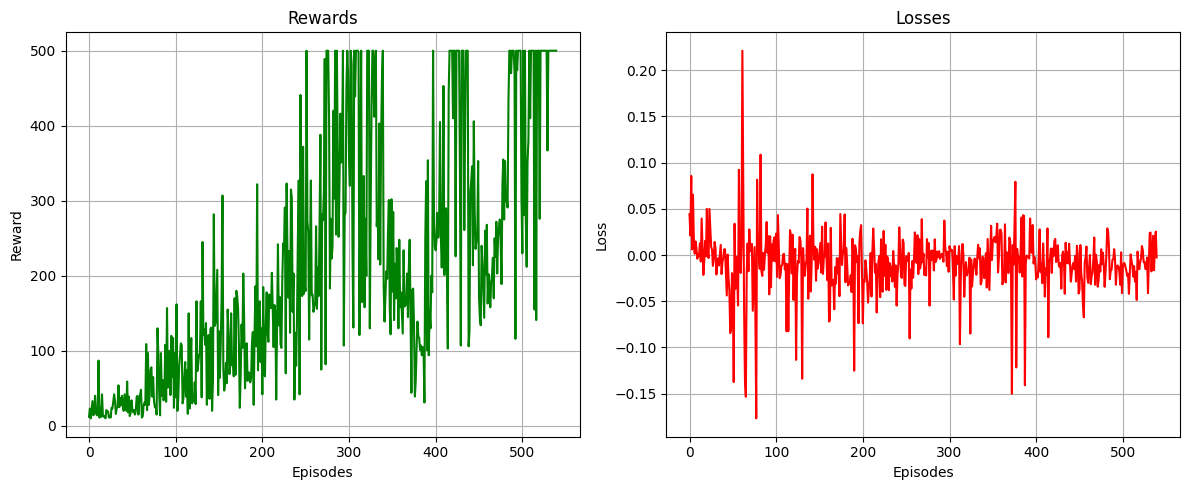

In [22]:
import matplotlib.pyplot as plt

def plot_train_results(results):
    rewards = results["episode_rewards"]
    policy_losses = results["episode_policy_losses"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create figure and subplots

    # First subplot for rewards
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Reward')
    axes[0].grid(True)
    axes[0].plot(rewards, color='green')
    axes[0].set_title('Rewards')

    # Second subplot for policy losses
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].plot(policy_losses, color='red')
    axes[1].set_title('Losses')

    plt.tight_layout()  # Adjusts spacing between plots

    plt.close(fig)  # Suppress automatic rendering

    return fig

plot_train_results(train_results)

We paused upon reaching our reward threshold 🎯 due to training instability. Continuing could lead to suboptimal behaviors ⚠️ and performance decline 📉. To train longer while minimizing this risk, we should save model snapshots 💾 whenever a new best reward is achieved 🏆, allowing us to revert to the best-performing version at the end of training 🔄.

## Evaluate Policy 📊📝

A good reward during training isn't sufficient; the true test is running the trained policy multiple times in the environment 🌍 to assess reward consistency. Averaging these rewards 📊 measures the policy's effectiveness.

In [23]:
from IPython.display import clear_output

def evaluate(
    env,
    model,
    n_episodes=10,
    use_wandb=None,
    wandb_project=None,
    seed=None,
    log=True
):
    if use_wandb is None: use_wandb = CONFIG["use_wandb"]
    if wandb_project is None: wandb_project = CONFIG.get("wandb_project", env.spec.id)
    if seed is None: seed = CONFIG["seed"]

    # In case wandb is enabled, initialize run
    if use_wandb: wandb.init(project=wandb_project, config=CONFIG)

    try:
        # Set seeds to make evaluations deterministic
        torch.manual_seed(seed)
        env.reset(seed=seed)

        # Set the model in evaluation mode
        model.eval()

        # Run evaluation for N episodes
        episode_rewards = []
        for episode in range(n_episodes):
            rewards, action_logprobs, frames = run_episode(env, model, train_mode=False)
            episode_reward = np.array(rewards).sum()
            episode_rewards.append(episode_reward)
            if log: print(f"Episode: {episode+1}, Avg Reward: {episode_reward}")

        # Print final stats
        mean_reward = np.mean(episode_rewards)
        if log: print(f"Mean reward over {n_episodes} episodes: {mean_reward}")

        # Render last run's video
        return render_video(frames)
    finally:
        # In case wandb is enabled, initialize run
        if use_wandb: wandb.finish()

evaluate(env, model, n_episodes=10)

Episode: 1, Avg Reward: 500.0
Episode: 2, Avg Reward: 500.0
Episode: 3, Avg Reward: 236.0
Episode: 4, Avg Reward: 500.0
Episode: 5, Avg Reward: 500.0
Episode: 6, Avg Reward: 294.0
Episode: 7, Avg Reward: 500.0
Episode: 8, Avg Reward: 500.0
Episode: 9, Avg Reward: 500.0
Episode: 10, Avg Reward: 500.0
Mean reward over 10 episodes: 453.0


## Keep Improving 🚀✨

And we're done! 🎉 To keep going, consider running these experiments:

- **Increase `LEARNING_RATE`**: Set to `0.01` to speed up training—observe if rewards increase faster. 🚀
- **Decrease `LEARNING_RATE`**: Lower to `0.001` for cautious updates—see how it stabilizes the learning curve. 📉
- **Modify `DISCOUNT_FACTOR`**: Use `0.95` to prioritize short-term rewards—plot results for changes. 📊
- **Enhance `HIDDEN_SIZE`**: Raise to `256` for a stronger network—test performance on the pole. 🏋️‍♂️
- **Increase `AVERAGE_REWARD_THRESHOLD`**: Raise to `500` to push policy toward near-perfect performance. 🌟
- **Increase `AVERAGE_REWARD_WINDOW`**: Ensure `AVERAGE_REWARD_THRESHOLD` is consistently surpassed. 🔄
- **Implement a baseline**: Subtract the average return from past episodes from `returns` before scaling to reduce variability. ⚖️
- **Explore different environments**: Run the codebase in similar environments like:
  - [Acrobot-v1](https://gymnasium.farama.org/environments/classic_control/acrobot/) 🤖
  - [MountainCar-v0](https://www.gymlibrary.dev/environments/classic_control/mountain_car/) ⛰️
  - [LunarLander-v3](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) 🌕
  - [Blackjack-v1](https://www.gymlibrary.dev/environments/toy_text/blackjack/) ♠️
  - [FrozenLake-v1](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) ❄️

Adjust parameters one at a time, rerun the code, and discover your optimal setup! 🔍

Let's setup some utils for you to be able to run multiple experiments with different hyperparameter configurations and compare how their results stack up:

In [24]:
import json
from tqdm import tqdm

def apply_config(config):
    # Apply provided config to global config, this will ensure
    # that running previously declared methods such as train
    # will make them behave differently as they rely on this config object
    global CONFIG
    for key, value in ORIGINAL_CONFIG.items(): CONFIG[key] = value
    for key, value in config.items(): CONFIG[key] = value
    return CONFIG

def run_experiment(config):
    # Merge experiment config, apply to
    # global config object and return it
    config = apply_config(config)

    # Log experiment start
    print()
    print(f"Experiment started: {json.dumps(config, indent=2)}")

    # Build enviroment from scratch
    env_id = config["env_id"]
    env = build_env(env_id)

    # Build policy model from scratch
    # (fresh new parameters)
    model = build_model(env)

    # Train the model
    train_results = train(env, model, log=False)

    # Evaluate the trained model
    eval_results = evaluate(env, model, log=False)

    # Log the end of the experiment
    result = {
        "config" : {**config},
        "train" : train_results,
        "eval" : eval_results
    }
    _train_results = {**train_results}
    del _train_results["episode_rewards"]
    del _train_results["episode_policy_losses"]
    print(f"Experiment finished: {json.dumps(_train_results, indent=2)}")

    # Return experiment result
    return result

def run_experiments(experiments):
    # Run all experiments and return the experiment results
    results = []
    for index, experiment in tqdm(enumerate(experiments), total=len(experiments), desc="Running Experiments"):
        result = run_experiment(experiment)
        results.append(result)
    return results

This is the default configuration:

In [25]:
ORIGINAL_CONFIG

{'seed': 42,
 'env_id': 'CartPole-v1',
 'discount_factor': 0.99,
 'hidden_size': 128,
 'learning_rate': 0.002,
 'n_train_episodes': 5000,
 'average_reward_window': 10,
 'average_reward_threshold': None,
 'normalize_returns': True,
 'use_log_probs': True,
 'use_wandb': True}

Define your experiments below by listing parameter variations you want to test. Each configuration will be applied to the base settings and executed sequentially. The results will show which configuration solved the environment in the fewest episodes:


In [26]:
experiments = [
    {
        "hidden_size" : 256
    }
]
results = run_experiments(experiments)
results = [x for x in results if x["train"]["solved"]]
results = sorted(results, key=lambda x: x["train"]["episodes"])
results[0]["config"]

Running Experiments:   0%|          | 0/1 [00:00<?, ?it/s]


Experiment started: {
  "seed": 42,
  "env_id": "CartPole-v1",
  "discount_factor": 0.99,
  "hidden_size": 256,
  "learning_rate": 0.002,
  "n_train_episodes": 5000,
  "average_reward_window": 10,
  "average_reward_threshold": null,
  "normalize_returns": true,
  "use_log_probs": true,
  "use_wandb": true
}


episode,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
policy_loss,▅▂▃▇█▄▁▂▁▃▂▁▃▄▂▃▃▃▂▄▂▃▂▃▂▂▃▃▂▂▃▃▂▃▃▂▂▃▂▃
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▂▃▃▃▃▃▄▄▁▃▄▃▃▃█▅▄▆▅█▅
avg_reward,488
elapsed,48.91461
episode,499
policy_loss,0.02193
reward,500
solved,True


Running Experiments: 100%|██████████| 1/1 [01:19<00:00, 79.65s/it]

Experiment finished: {
  "solved": true,
  "elapsed": 48.91460919380188,
  "episodes": 499
}


{'seed': 42,
 'env_id': 'CartPole-v1',
 'discount_factor': 0.99,
 'hidden_size': 256,
 'learning_rate': 0.002,
 'n_train_episodes': 5000,
 'average_reward_window': 10,
 'average_reward_threshold': None,
 'normalize_returns': True,
 'use_log_probs': True,
 'use_wandb': True}